In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings

# Suppress warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Read In Data

In [4]:
# Reading in the training data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# remove id columns from both
test_ids = test_df['PassengerId']

# print the train_df head
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
# Isolate target 'Transported'
target = train_df['Transported']
train_df.drop(columns = ['Transported'], inplace = True)

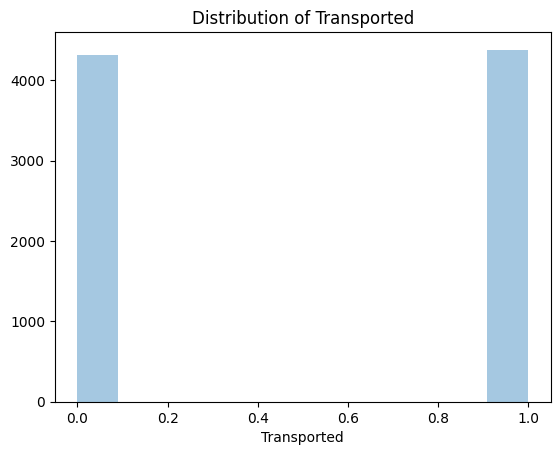

In [6]:
# plot hist
def plot_transported():
    fig, ax = plt.subplots()
    sns.distplot(target, ax=ax, kde=False)
    ax.set_title("Distribution of Transported")
    
# target
plot_transported()

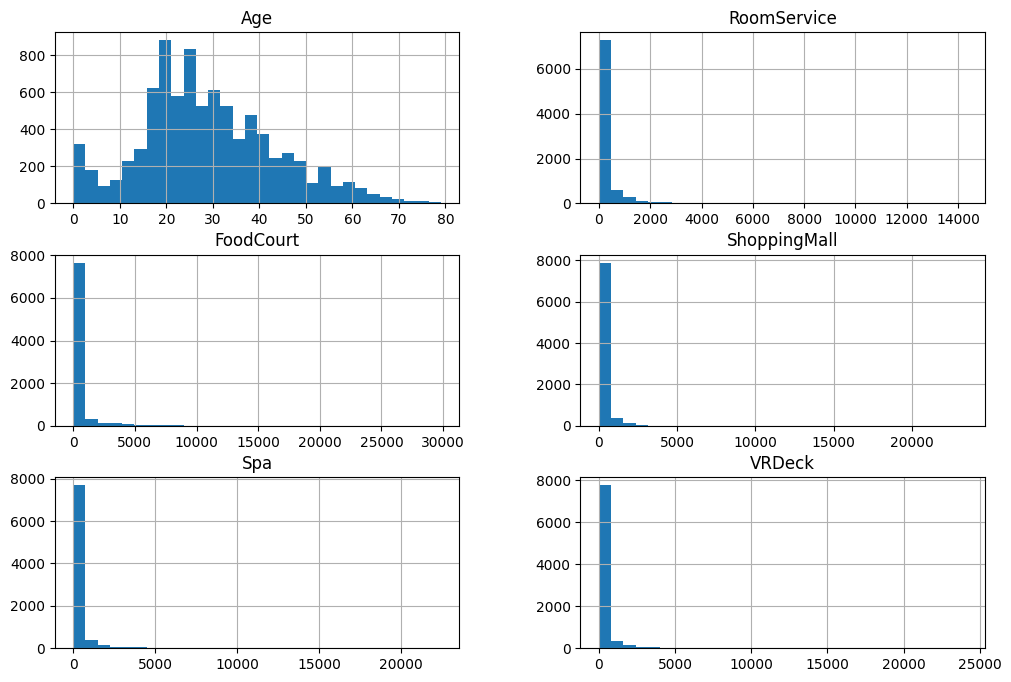

In [7]:
# Histograms
train_df.hist(bins=30, figsize=(12, 8))
plt.show()

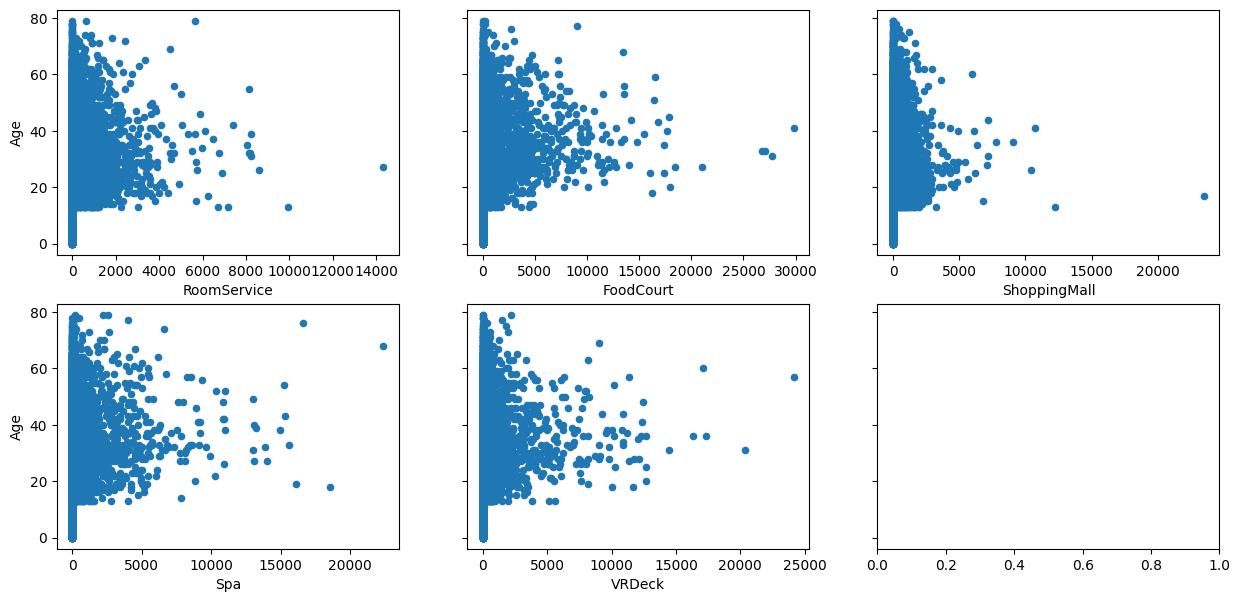

In [64]:
# Looking for outliers
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 7))
train_df.plot.scatter(x='RoomService', y='Age', ax=axes[0, 0])
train_df.plot.scatter(x='FoodCourt', y='Age', ax=axes[0, 1])
train_df.plot.scatter(x='ShoppingMall', y='Age', ax=axes[0, 2])
train_df.plot.scatter(x='Spa', y='Age', ax=axes[1, 0])
train_df.plot.scatter(x='VRDeck', y='Age', ax=axes[1, 1])
plt.show()

In [65]:
# Cap RoomService at 9000
train_df.loc[train_df.RoomService.gt(9000), 'RoomService'] = 9000

# Cap FoodCourt at 20000
train_df.loc[train_df.FoodCourt.gt(20000), 'FoodCourt'] = 20000

# Cap ShoppingMall at 10000
train_df.loc[train_df.ShoppingMall.gt(10000), 'ShoppingMall'] = 10000

# Cap Spa at 17000
train_df.loc[train_df.Spa.gt(17000), 'Spa'] = 17000

# Cap VRDeck at 19000
train_df.loc[train_df.VRDeck.gt(19000), 'VRDeck'] = 19000

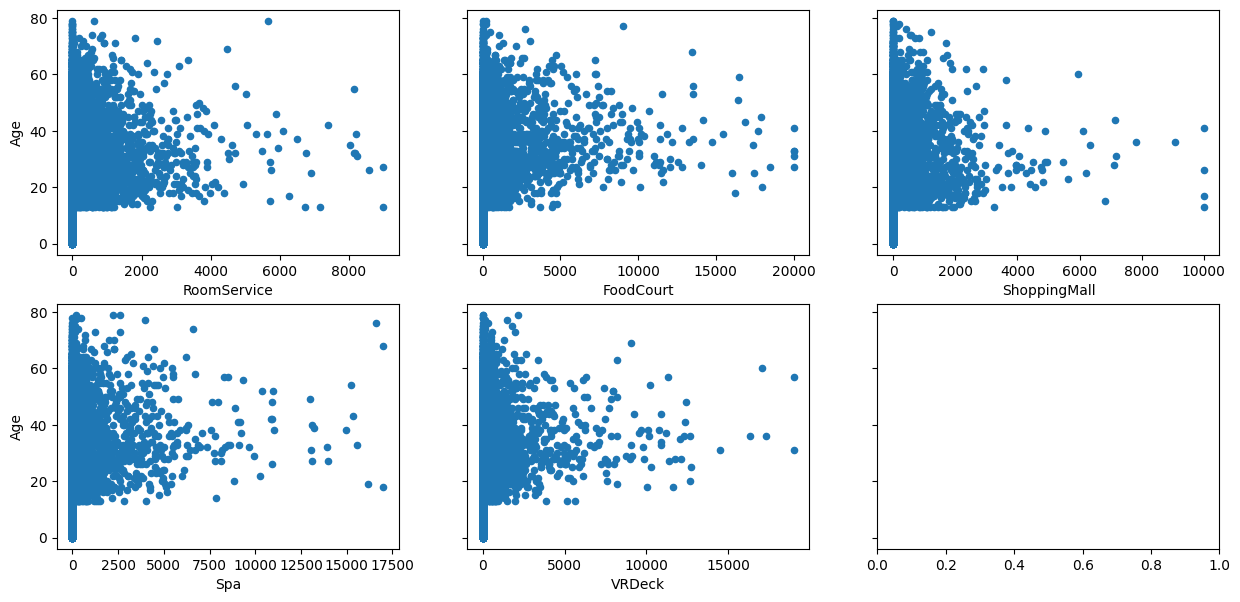

In [66]:
# Looking for outliers
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(15, 7))
train_df.plot.scatter(x='RoomService', y='Age', ax=axes[0, 0])
train_df.plot.scatter(x='FoodCourt', y='Age', ax=axes[0, 1])
train_df.plot.scatter(x='ShoppingMall', y='Age', ax=axes[0, 2])
train_df.plot.scatter(x='Spa', y='Age', ax=axes[1, 0])
train_df.plot.scatter(x='VRDeck', y='Age', ax=axes[1, 1])
plt.show()

# Concatonating Train and Test

In [8]:
# Joining each train and test counterpart df
def concat_dataframes(df_1, df_2):
    df_1_copy = df_1.copy()  # Work on a copy to avoid SettingWithCopyWarning
    df_2_copy = df_2.copy()  # Work on a copy to avoid SettingWithCopyWarning
    
    df_1_copy['From_df_1'] = True
    df_2_copy['From_df_1'] = False
    
    # Concatenate the dataframes
    return pd.concat([df_1_copy, df_2_copy], ignore_index=True)
#Test

In [9]:
# seperate train and test
def get_seperate_dataframes(concatenated_df):
    df_1 = concatenated_df[concatenated_df['From_df_1'] == True].drop(columns=['From_df_1'])
    df_2 = concatenated_df[concatenated_df['From_df_1'] == False].drop(columns=['From_df_1'])
    
    return df_1, df_2

In [10]:
# concat
all_df = concat_dataframes(train_df, test_df)

In [11]:
# convert bools to ints
bool_columns = all_df.select_dtypes(include=['bool']).columns
all_df[bool_columns] = all_df[bool_columns].astype(int)

# Preliminary Feature Engineering

In [12]:
# First, lets separate the data in the cabin column into it's respective pieces of data
cabin_split = all_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']
new_df = pd.concat([all_df, cabin_split], axis=1)
all_df = new_df
all_df.drop(columns=['Cabin'], inplace=True)

In [13]:
# Passenger ID into group ID
id_split = all_df['PassengerId'].str.split('_', expand=True)
id_split.columns = ['GroupId', "Index"]
new_df = pd.concat([all_df, id_split], axis=1)
all_df = new_df
all_df.drop(columns=['PassengerId', 'Index'], inplace=True)
all_df['GroupId'] = all_df['GroupId'].astype(int)

train_df.drop(columns=['PassengerId'])
test_df.drop(columns=['PassengerId'])

all_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,From_df_1,Deck,Room_Number,Side,GroupId
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,B,0,P,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0,S,2
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,1,A,0,S,3
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,1,A,0,S,3
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1,S,4


In [14]:
# Adding a TotalSpending feature
all_df['TotalSpend'] = all_df['RoomService'] + all_df['FoodCourt'] + all_df['ShoppingMall'] + all_df['Spa'] + all_df['VRDeck']
all_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,From_df_1,Deck,Room_Number,Side,GroupId,TotalSpend
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,1,B,0,P,1,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,F,0,S,2,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,1,A,0,S,3,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,1,A,0,S,3,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,F,1,S,4,1091.0


# Preliminary Data Investigation

Seperating data Types

In [15]:
#Break all_data into categorical and numerical dataframes
categorical_df = all_df.select_dtypes(include=['object', 'bool'])
numerical_df = all_df.select_dtypes(include=['int64', 'float64'])

##Remove Name and Room_Number from categorical_df
numerical_df['Room_Number'] = categorical_df['Room_Number']
categorical_df = categorical_df.drop(columns=['Name', 'Room_Number'])

print(categorical_df.columns)
print(numerical_df.columns)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'], dtype='object')
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'From_df_1', 'GroupId', 'TotalSpend', 'Room_Number'],
      dtype='object')


In [16]:
# Plotting bar graphs to inspect categorical data      ---------> Should come sooner 
# List of feature names in the DataFrame
# feature_names = categorical_df.columns.tolist()

# # Number of rows/columns for the subplot grid
# n_rows = len(feature_names) // 3 + (len(feature_names) % 3 > 0)
# n_cols = 3

# # Create a subplot grid
# plt.figure(figsize=(20, n_rows * 5))  # Adjust the size as needed

# for i, feature_name in enumerate(feature_names):
#     ax = plt.subplot(n_rows, n_cols, i + 1)
#     # Generate a countplot
#     sns_plot = sns.countplot(x=feature_name, data=categorical_df, 
#                              palette="tab20", ax=ax)
#     plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#     plt.title(feature_name)

#     # Add counts above bars
#     for p in sns_plot.patches:
#         sns_plot.annotate(format(p.get_height(), '.0f'), 
#                           (p.get_x() + p.get_width() / 2., p.get_height()), 
#                           ha = 'center', va = 'center', 
#                           xytext = (0, 10), 
#                           textcoords = 'offset points')

# plt.tight_layout()
# plt.show()

In [17]:
# all feature pair plot
def plot_all_field_relationships(df):
    # Handle categorical data: Convert to numeric codes for correlation analysis (optional)
    # This step is simplistic and may not be meaningful for non-ordinal categories.
    df_numeric = df.copy()
    for col in df_numeric.select_dtypes(include=['object', 'bool']).columns:
        df_numeric[col] = df_numeric[col].astype('category').cat.codes

    # Pair Plot for numeric fields (considering the whole DataFrame may be too much, so focus on key fields)
    # Selecting a subset of fields if necessary due to the broad scope and to avoid overwhelming plots
    numeric_cols = df_numeric.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 10:  # limiting to first 10 numeric columns to keep the plot readable
        numeric_cols = numeric_cols[:10]
    sns.pairplot(df_numeric[numeric_cols], corner=True)
    plt.suptitle('Pairwise relationships of Numeric Features', y=1.02)
    plt.show()

# plot_all_field_relationships(train_df)

# Eliminating Nans

In [18]:
# Initial missing values
all_df.isna().sum()

HomePlanet       288
CryoSleep        310
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
From_df_1          0
Deck             299
Room_Number      299
Side             299
GroupId            0
TotalSpend      1363
dtype: int64

HomePlanet

In [19]:
# check homeplanet group dependencies
planets = all_df.groupby(['GroupId'])['HomePlanet'].nunique()
planets = planets[planets > 1]
print(planets)

Series([], Name: HomePlanet, dtype: int64)


In [20]:
# Define the columns to impute and the group column
columns_to_impute = ['HomePlanet']
group_column = 'GroupId'

# Calculate the mode for each column within each GroupId
# We loop over each column to impute since pd.Series.mode() might return multiple values
for column in columns_to_impute:
    # Compute the mode for the current column grouped by GroupId
    mode_series = all_df.groupby(group_column)[column].apply(lambda x: pd.Series.mode(x.dropna()).iloc[0] if not x.dropna().empty else np.NaN)
    
    # Convert the Series into a DataFrame with a reset index, naming the columns appropriately
    mode_df = mode_series.reset_index(name=f'{column}_mode')
    
    # Merge the mode values back into the original DataFrame
    all_df = pd.merge(all_df, mode_df, on=group_column, how='left')
    
    # Impute missing values in the original column with the mode values
    all_df[column] = np.where(all_df[column].isna(), all_df[f'{column}_mode'], all_df[column])
    
    # Drop the temporary mode column used for imputation
    all_df.drop(columns=[f'{column}_mode'], inplace=True)

In [21]:
# checking deck homeplanet dependencies
# plt.figure(figsize=(12, 6))
# sns.countplot(data=all_df, x='Deck', hue='HomePlanet', palette='Set2')
# plt.title('Counts of Deck for each HomePlanet')
# plt.xlabel('Deck')
# plt.ylabel('Count')
# plt.xticks(rotation=45)  # Rotate labels to improve readability if necessary
# plt.legend(title='HomePlanet', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
# plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels and legend
# plt.show()

In [22]:
impute_columns = ['HomePlanet']
earth_decks = (all_df['Deck'] == 'G')
europa_decks = (all_df['Deck'] == 'B') | (all_df['Deck'] == 'A') | (all_df['Deck'] == 'T') | (all_df['Deck'] == 'C')
all_df.loc[earth_decks, impute_columns] = all_df.loc[earth_decks, impute_columns].fillna('Earth')
all_df.loc[europa_decks, impute_columns] = all_df.loc[europa_decks, impute_columns].fillna('Europa')

In [23]:
# plt.figure(figsize=(12, 6))
# sns.countplot(data=all_df, x='HomePlanet', hue='Destination', palette='Set2')
# plt.title('Counts of Deck for each HomePlanet')
# plt.xlabel('Deck')
# plt.ylabel('Count')
# plt.xticks(rotation=45)  # Rotate labels to improve readability if necessary
# plt.legend(title='Destination', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
# plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels and legend
# plt.show()

In [24]:
impute_columns = ['HomePlanet']
to_pso = (all_df['Destination'] == 'PSO J318.5-22')
all_df.loc[to_pso, impute_columns] = all_df.loc[to_pso, impute_columns].fillna('Earth')

Room_Number

In [25]:
# check grouppID room number dependencies
room_counts_family = all_df.groupby(['GroupId'])['Room_Number'].nunique()
multiple_rooms_family = room_counts_family[room_counts_family > 3]
print(multiple_rooms_family)

Series([], Name: Room_Number, dtype: int64)


In [26]:
# impute Room_Number, Deck, Side Based on Family

# Define the columns to impute and the group column
columns_to_impute = ['Room_Number', 'Deck', 'Side']
group_column = 'GroupId'

# Calculate the mode for each column within each GroupId
# We loop over each column to impute since pd.Series.mode() might return multiple values
for column in columns_to_impute:
    # Compute the mode for the current column grouped by GroupId
    mode_series = all_df.groupby(group_column)[column].apply(lambda x: pd.Series.mode(x.dropna()).iloc[0] if not x.dropna().empty else np.NaN)
    
    # Convert the Series into a DataFrame with a reset index, naming the columns appropriately
    mode_df = mode_series.reset_index(name=f'{column}_mode')
    
    # Merge the mode values back into the original DataFrame
    all_df = pd.merge(all_df, mode_df, on=group_column, how='left')
    
    # Impute missing values in the original column with the mode values
    all_df[column] = np.where(all_df[column].isna(), all_df[f'{column}_mode'], all_df[column])
    
    # Drop the temporary mode column used for imputation
    all_df.drop(columns=[f'{column}_mode'], inplace=True)

CryoSleep Nans

In [27]:
# check cryosleep dependencies
temp_df = all_df.copy()
true_cond = (temp_df['RoomService'] == 0) & (temp_df['VRDeck'] == 0) & (temp_df['FoodCourt'] == 0) & (temp_df['ShoppingMall'] == 0) & (temp_df['Spa'] == 0) & (temp_df['Age'] >= 13)
false_cond = (temp_df['RoomService'] > 0) | (temp_df['VRDeck'] > 0) | (temp_df['FoodCourt'] > 0) | (temp_df['ShoppingMall'] > 0) | (temp_df['Spa'] > 0)
temp_df = temp_df[true_cond]
temp_df.groupby(['CryoSleep']).nunique()

,HomePlanet,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,From_df_1,Deck,Room_Number,Side,GroupId,TotalSpend
CryoSleep,,,,,,,,,,,,,,,,
False,3,1,43,2,1,1,1,1,1,126,2,7,114,2,129,1
True,3,3,64,2,1,1,1,1,1,3410,2,7,1367,2,3070,1


In [28]:
all_df.loc[true_cond, ['CryoSleep']] = all_df.loc[true_cond, ['CryoSleep']].fillna(1)
all_df.loc[false_cond, ['CryoSleep']] = all_df.loc[false_cond, ['CryoSleep']].fillna(0)

VIP Nans

In [29]:
# checking underaged VIPs
vip_age = all_df.groupby(['Age'])['VIP'].mean()
# vip_age.head(20)

In [30]:
# impute vips based on underaged
impute_columns = ['VIP']
under_aged = (all_df['Age'] < 18)
all_df.loc[under_aged, impute_columns] = all_df.loc[under_aged, impute_columns].fillna(0)

In [31]:
vip_home = all_df.groupby(['HomePlanet'])['VIP'].mean()
# vip_home.head(20)

In [32]:
impute_columns = ['VIP']
from_earth = (all_df['HomePlanet'] == 'Earth')
all_df.loc[from_earth, impute_columns] = all_df.loc[from_earth, impute_columns].fillna(False)

In [33]:
# plt.figure(figsize=(12, 6))
# sns.countplot(data=all_df, x='CryoSleep', hue='Deck', palette='Set2')
# plt.title('Counts of Deck for each HomePlanet')
# plt.xlabel('Deck')
# plt.ylabel('Count')
# plt.xticks(rotation=45)  # Rotate labels to improve readability if necessary
# plt.legend(title='HomePlanet', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
# plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels and legend
# plt.show()

In [34]:
# checking cryo VIP dependencies
vip_cryo = all_df.groupby(['CryoSleep'])['VIP'].mean()
print(vip_cryo)

CryoSleep
False    0.029936
True     0.006054
Name: VIP, dtype: float64


In [35]:
# Impute nans
vip_column = ['VIP']
cryo = (all_df['CryoSleep'] == 1)
all_df.loc[cryo, vip_column] = all_df.loc[cryo, vip_column].fillna(0)

Spending Nans

In [36]:
def plot_spending_relationships_categorical(df, category_column, spending_categories):
    # Melt the DataFrame to make it suitable for sns.catplot
    melted_df = df.melt(id_vars=[category_column], value_vars=spending_categories,
                        var_name='SpendingCategory', value_name='AmountSpent')
    
    # Plotting
    sns.catplot(x='SpendingCategory', y='AmountSpent', hue=category_column, kind='bar', data=melted_df, height=6, aspect=2)
    plt.title(f'Spending in Various Categories Based on {category_column} Status')
    plt.xticks(rotation=45)
    plt.show()

In [37]:
# cryo versus amount spent in all spenidng categories
# plot_spending_relationships_categorical(all_df, 'CryoSleep', ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [38]:
# HomePlanet and spending
# plot_spending_relationships_categorical(all_df, 'HomePlanet', ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

In [39]:
# Impute nans
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cryo = (all_df['CryoSleep'] == 1)
all_df.loc[cryo, spending_columns] = all_df.loc[cryo, spending_columns].fillna(0)

In [40]:
# checking age cuttoff for spending
all_copy = all_df.copy()
all_copy['TotalSpend'] = all_copy['RoomService'] + all_copy['FoodCourt'] + all_copy['ShoppingMall'] + all_copy['Spa'] + all_copy['VRDeck']
all_copy.head()
age_spending = all_copy.groupby(['Age'])['TotalSpend'].mean()
# age_spending.head(18)

In [41]:
# imputing spending for underaged
spending_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
under_aged = (all_df['Age'] < 13)
all_df.loc[under_aged, spending_columns] = all_df.loc[under_aged, spending_columns].fillna(0)

In [ ]:
# investigate how many have 4 0

In [ ]:
# imputing 0 for spending cateory if all others are 0

### TODO: Fix top graph

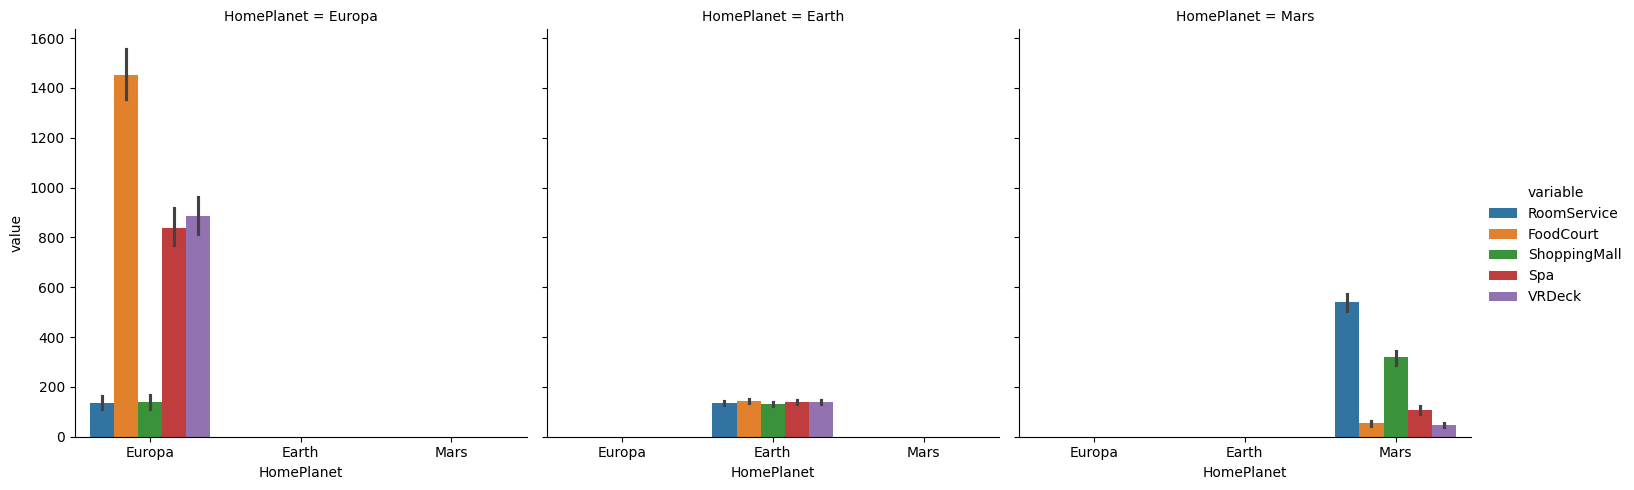

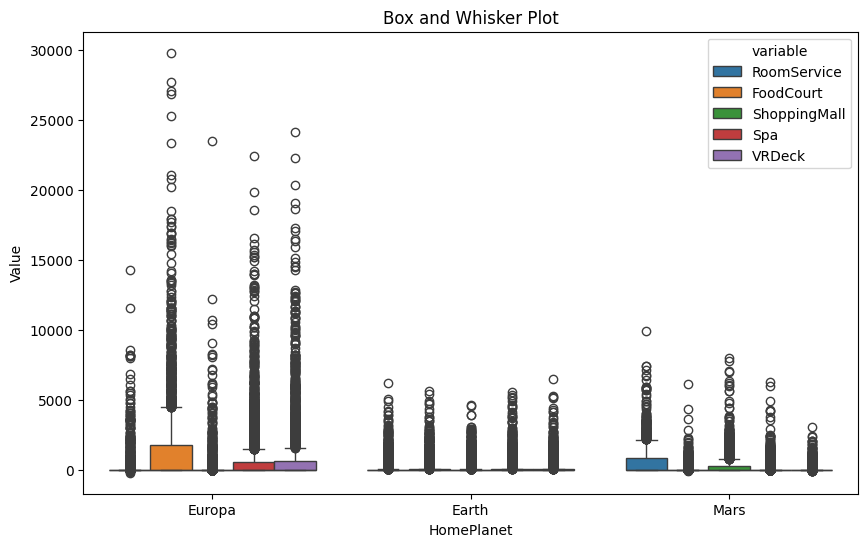

In [67]:
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet']

# Create a subset of the dataframe with the selected columns
subset_df = all_df[columns]

# Melt the dataframe to get 'value' and 'variable' columns
melted_df = pd.melt(subset_df, id_vars=['HomePlanet'], value_vars=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

# Plot the values
sns.catplot(data=melted_df, kind='bar', x='HomePlanet', y='value', hue='variable', col='HomePlanet', col_wrap=3)
# Plot the values as a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_df, x='HomePlanet', y='value', hue='variable')
plt.title('Box and Whisker Plot')
plt.xlabel('HomePlanet')
plt.ylabel('Value')
plt.show()

In [ ]:
# impute based on homeplanet
true_cond = (all_df['FoodCourt'] > 6500) | (all_df['ShoppingMall'] > 8000) | (all_df['Spa'] > 6500) | (all_df['VRDeck'] > 6500)
all_df.loc[true_cond, ['HomePlanet']] = all_df.loc[true_cond, ['HomePlanet']].fillna('Europa')

Age Nans

In [42]:
# PUT IN AGE REGRESSION

# temp_df = all_df.copy()
# true_cond = (temp_df['TotalSpend'] == 0) & (temp_df['CryoSleep'] == 0)
# temp_df = temp_df[true_cond]
# temp_df.groupby(['Age']).nunique()


Smart Impuation

In [43]:
# Categorical
def impute_with_classification_and_evaluate(df, feature_names, target_name):
    # Copy the DataFrame to avoid changing the original data
    df_copy = df.copy()
    df_copy_2 = df.copy()
    df_copy = df_copy[feature_names]
    df_copy[target_name] = df_copy_2[target_name]
    
    # Identify specified categorical features for encoding
    categorical_features = [col for col in feature_names if col in df_copy.select_dtypes(include=['object']).columns]
    
    # Encode specified categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df_copy[categorical_features]).toarray()
    encoded_df = pd.DataFrame(encoded_features, index=df_copy.index, columns=encoder.get_feature_names_out(categorical_features))
    
    # Drop the original categorical columns from df_copy
    df_copy = df_copy.drop(columns=categorical_features)
    
    # Combine the encoded features with the rest of the data
    # Ensure we only add back the encoded columns that were specified in feature_names
    df_copy = pd.concat([df_copy, encoded_df], axis=1)
    
    # Rest of the function remains the same
    # Split the data into rows with known and unknown target values
    known_target = df_copy.dropna(subset=[target_name])
    unknown_target = df_copy[df_copy[target_name].isnull()]
    
    X_known = known_target.drop(columns=[target_name])
    y_known = known_target[target_name]
    
    # Ensure the target variable is appropriate for classification
    # Check and convert y_known to categorical if it's not already
    if not pd.api.types.is_categorical_dtype(y_known):
        y_known = y_known.astype('category')

    # Now check for NaN values in y_known - this should be empty given your current logic
    if y_known.isnull().any():
        raise ValueError("y_known contains NaN values, which is not supported for classification tasks.")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)
    
    # Now we proceed with creating and training the RandomForestClassifier
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    
    y_pred_test = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Accuracy on {target_name}: {accuracy}")
    
    classifier.fit(X_known, y_known)
    
    X_unknown = unknown_target.drop(columns=[target_name])
    predicted_values = classifier.predict(X_unknown)
    
    df.loc[df[target_name].isnull(), target_name] = predicted_values

    return df

In [44]:
# Numeric
def impute_with_regression_and_evaluate(df, feature_names, target_name):
    # Copy the DataFrame to avoid changing the original data
    df_copy = df.copy()
    
    # Identify categorical features for encoding
    categorical_features = df_copy[feature_names].select_dtypes(include=['object', 'bool']).columns.tolist()
    
    # Encode categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_features = encoder.fit_transform(df_copy[categorical_features]).toarray()
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
    
    # Combine the encoded features with the rest of the data
    df_copy = pd.concat([df_copy.drop(columns=categorical_features), encoded_df], axis=1)
    
    # Split the data into rows with known and unknown target values
    known_target = df_copy.dropna(subset=[target_name])
    unknown_target = df_copy[df_copy[target_name].isnull()]
    
    # Further split known target data into training and testing sets for model evaluation
    X_known = known_target[encoder.get_feature_names_out(categorical_features)]
    y_known = known_target[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)
    
    # Train the linear regression model on the training set
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict target for the test set and calculate RMSE for evaluation
    y_pred_test = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"RMSE for {target_name}: {rmse}")
    
    # Retrain the model on all known data
    model.fit(X_known, y_known)
    
    # Predict target for rows where it's unknown
    X_unknown = unknown_target[encoder.get_feature_names_out(categorical_features)]
    predicted_values = model.predict(X_unknown)
    
    # Fill in the missing values with the predictions
    df.loc[df[target_name].isnull(), target_name] = predicted_values

    return df

In [45]:
# Spendings
#-------------------------------------------------------------------------------------------------------------------------------
# RoomService
all_df = impute_with_regression_and_evaluate(all_df, ['HomePlanet', 'Deck', 'VIP', 'Destination', 'TotalSpend'], 'RoomService')
# FoodCourt
all_df = impute_with_regression_and_evaluate(all_df, ['HomePlanet', 'Deck', 'VIP', 'Destination'], 'FoodCourt')
# ShoppingMall
all_df = impute_with_regression_and_evaluate(all_df, ['HomePlanet', 'Deck', 'VIP', 'Destination'], 'ShoppingMall')
# VRDeck
all_df = impute_with_regression_and_evaluate(all_df, ['HomePlanet', 'Deck', 'VIP', 'Destination'], 'VRDeck')
# Spa
all_df = impute_with_regression_and_evaluate(all_df, ['HomePlanet', 'Deck', 'VIP', 'Destination'], 'Spa')
#-------------------------------------------------------------------------------------------------------------------------------
# Age
all_df = impute_with_regression_and_evaluate(all_df, ['HomePlanet', 'Deck', 'VIP', 'Destination', 'CryoSleep', 'TotalSpend'], 'Age')
#-------------------------------------------------------------------------------------------------------------------------------
# CryoSleep
all_df = impute_with_classification_and_evaluate(all_df, ['HomePlanet', 'Deck', 'VIP', 'Destination', 'TotalSpend'], 'CryoSleep')
#-------------------------------------------------------------------------------------------------------------------------------
# HomePlanet
all_df = impute_with_classification_and_evaluate(all_df, ['GroupId', 'Deck', 'VIP', 'Destination', 'RoomService', 'TotalSpend', 'VRDeck', 'Spa', 'ShoppingMall', 'FoodCourt'], 'HomePlanet')
#-------------------------------------------------------------------------------------------------------------------------------
# Deck
all_df = impute_with_classification_and_evaluate(all_df, ['GroupId', 'VIP', 'RoomService', 'TotalSpend', 'VRDeck', 'Spa', 'ShoppingMall', 'FoodCourt'], 'Deck')
#-------------------------------------------------------------------------------------------------------------------------------
# Side
all_df = impute_with_classification_and_evaluate(all_df, ['GroupId'], 'Side')
#-------------------------------------------------------------------------------------------------------------------------------
# # Room_Number
all_df = impute_with_classification_and_evaluate(all_df, ['GroupId'], 'Room_Number')
#-------------------------------------------------------------------------------------------------------------------------------
# Destination
all_df = impute_with_classification_and_evaluate(all_df, ['GroupId', 'HomePlanet'], 'Destination')
#-------------------------------------------------------------------------------------------------------------------------------
# VIP
all_df = impute_with_classification_and_evaluate(all_df, ['GroupId', 'Room_Number', 'Deck', 'TotalSpend', 'RoomService', 'TotalSpend', 'VRDeck', 'Spa', 'ShoppingMall', 'FoodCourt'], 'VIP')



RMSE for RoomService: 630.8526853349908
RMSE for FoodCourt: 1390.9741362283664


RMSE for ShoppingMall: 485.6174773953515
RMSE for VRDeck: 1139.5093768469744
RMSE for Spa: 1105.9400249929001
RMSE for Age: 13.90810743036368
Accuracy on CryoSleep: 0.9130266718206417
Accuracy on HomePlanet: 0.9417927823050058
Accuracy on Deck: 0.5921155347384855
Accuracy on Side: 0.7103825136612022
Accuracy on Room_Number: 0.3321623731459797
Accuracy on Destination: 0.581496062992126
Accuracy on VIP: 0.9724912824486633


Update TotalSpend

In [46]:
all_df['TotalSpend'] = all_df['RoomService'] + all_df['FoodCourt'] + all_df['ShoppingMall'] + all_df['Spa'] + all_df['VRDeck']

In [47]:
# final missing values
all_df.isna().sum()

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            294
From_df_1         0
Deck              0
Room_Number       0
Side              0
GroupId           0
TotalSpend        0
dtype: int64

# Feature Engineering

In [48]:
all_df['IsUnderaged'] = (all_df['Age'] < 13).astype(int)

# Data Encoding

In [49]:
#final break all_data into categorical and numerical dataframes
categorical_df = all_df.select_dtypes(include=['object', 'bool'])
numerical_df = all_df.select_dtypes(include=['int64', 'float64'])

##Remove Name and Room_Number from categorical_df
numerical_df['Room_Number'] = categorical_df['Room_Number'].astype(int)
categorical_df = categorical_df.drop(columns=['Name', 'Room_Number'])

print(categorical_df.columns)
print(numerical_df.columns)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'], dtype='object')
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'From_df_1', 'GroupId', 'TotalSpend', 'IsUnderaged', 'Room_Number'],
      dtype='object')


In [50]:
# Join target to the data frame
categorical_with_target_df = categorical_df.copy()
categorical_with_target_df['Transported'] = target

In [51]:
def get_ordered_category(category_name):
    mean_prices = categorical_with_target_df.groupby(category_name)['Transported'].mean()
    category_mean_dict = mean_prices.to_dict()
    sorted_categories = sorted(category_mean_dict, key=category_mean_dict.get)
    return sorted_categories

In [52]:
categorical_cols = categorical_df.columns
column_transformer = ColumnTransformer(transformers=[])

# Create a list to store the ordered catogories for each column
ordered_categories_list = []

for col in categorical_cols:
    ordered_categories = get_ordered_category(col)
    ordered_categories_list.append(ordered_categories)
    ode_pipeline = Pipeline(steps=[
        ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[ordered_categories]))
    ])

    column_transformer.transformers.append((col, ode_pipeline, [col]))

# Fit and transform the ColumnTransformer on the entire DataFrame
categorical_df_encoded = column_transformer.fit_transform(categorical_df)

# Convert the result back to a DataFrame with the original column names
categorical_df_encoded = pd.DataFrame(categorical_df_encoded, columns=categorical_cols)

categorical_df_encoded.head()

,HomePlanet,CryoSleep,Destination,VIP,Deck,Side
0,2.0,0.0,0.0,1.0,7.0,0.0
1,0.0,0.0,0.0,1.0,3.0,1.0
2,2.0,0.0,0.0,0.0,4.0,1.0
3,2.0,0.0,0.0,1.0,4.0,1.0
4,0.0,0.0,0.0,1.0,3.0,1.0


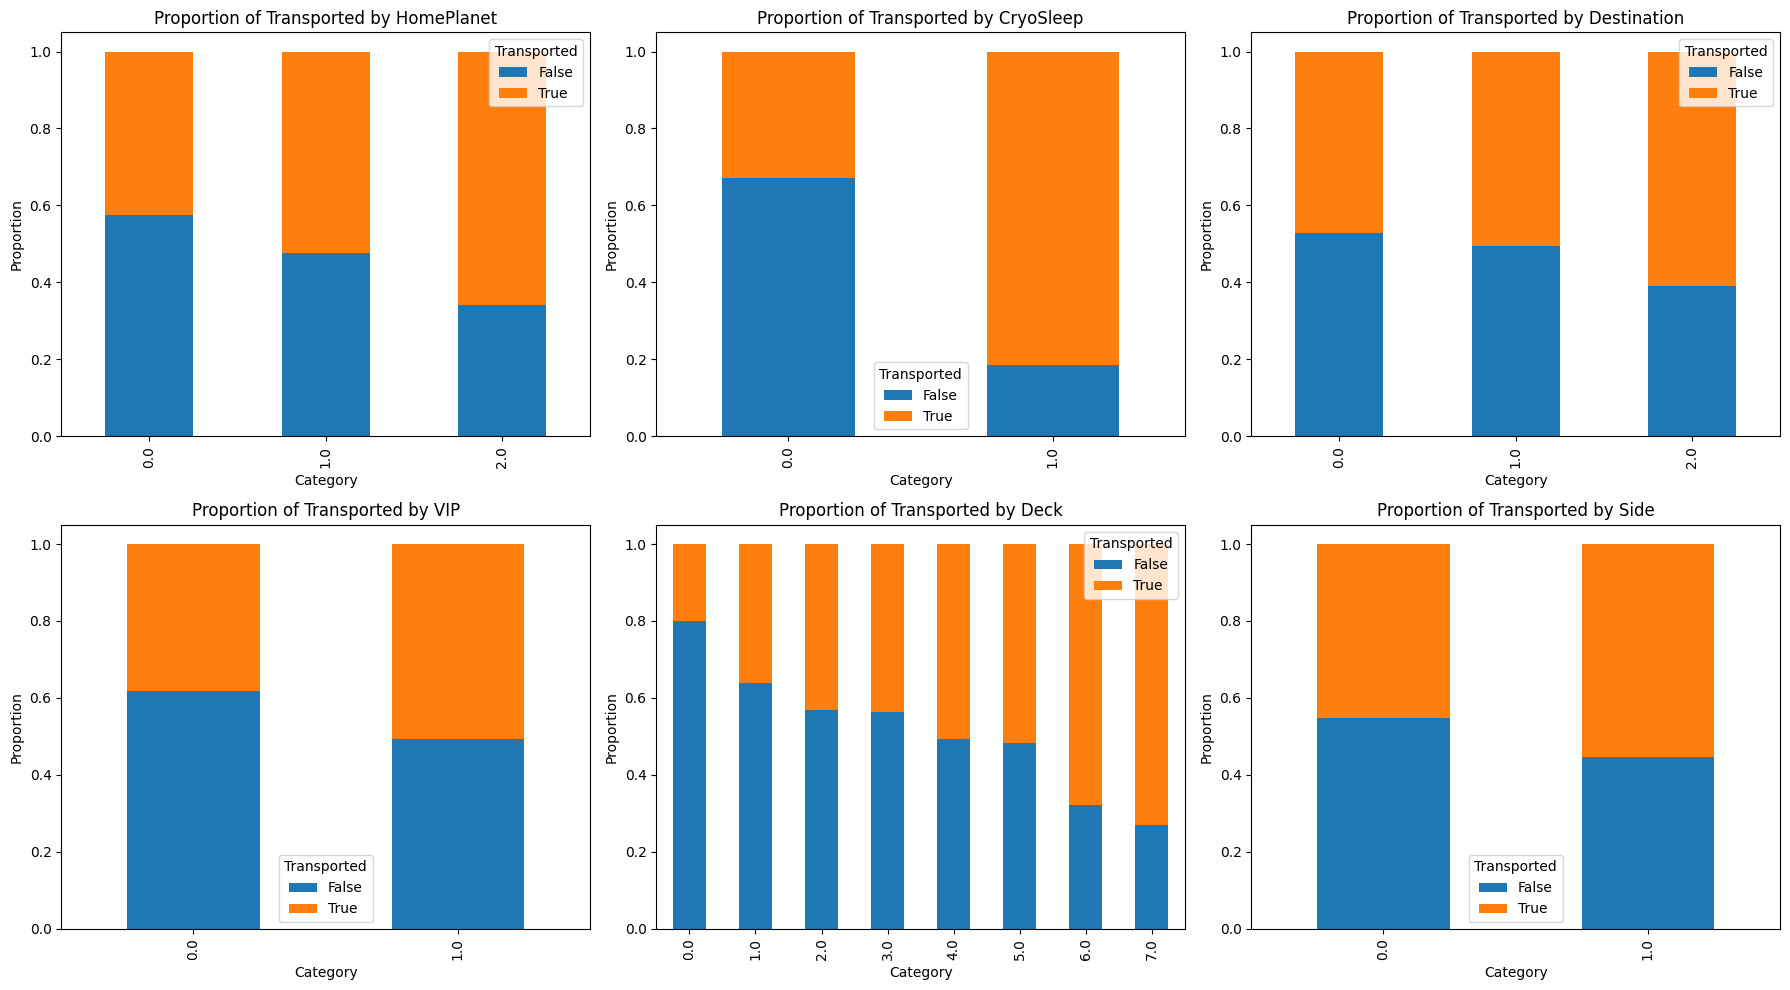

In [53]:
num_categorical_columns = len(categorical_df_encoded.columns)
n_cols = 3
n_rows = num_categorical_columns // n_cols + (num_categorical_columns % n_cols > 0)

# Create a subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

categorical_df_encoded_plot = categorical_df_encoded.copy()
categorical_df_encoded_plot['Transported'] = target

for i, column in enumerate(categorical_df_encoded.columns):
    ax = axes[i]

    # Calculate the percentage of each class per category value
    class_proportions = categorical_df_encoded_plot.groupby(column)["Transported"].value_counts(normalize=True).unstack().fillna(0)
    sorted_proportions = class_proportions.sort_values(by=True)

    # Plot the sorted DataFrame in the ith subplot
    sorted_proportions.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('Proportion of Transported by ' + column)
    ax.set_xlabel('Category')
    ax.set_ylabel('Proportion')
    ax.legend(title='Transported')

# If there are subplots that are empty (when num of plots is not a multiple of n_cols), hide them
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


In [54]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Fit the scaler to the data and transform it
encoded_df_normalized = pd.DataFrame(scaler.fit_transform(categorical_df_encoded), columns=categorical_df_encoded.columns)
# encoding
encoded_df = pd.concat([numerical_df, encoded_df_normalized], axis=1)

encoded_df.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,From_df_1,GroupId,TotalSpend,IsUnderaged,Room_Number,HomePlanet,CryoSleep,Destination,VIP,Deck,Side
0,39.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0,0,1.0,0.0,0.0,1.0,1.000000,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,2,736.0,0,0,0.0,0.0,0.0,1.0,0.428571,1.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,1,3,10383.0,0,0,1.0,0.0,0.0,0.0,0.571429,1.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,1,3,5176.0,0,0,1.0,0.0,0.0,1.0,0.571429,1.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,4,1091.0,0,1,0.0,0.0,0.0,1.0,0.428571,1.0


# Random Forest

In [55]:
# Custom transformer to convert all data to strings
class ConvertToString(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.astype(str)

In [56]:
new_train_df, new_test_df = get_seperate_dataframes(all_df)

# Identify categorical and numerical columns
numerical_features = ['Room_Number', 'Age', 'RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
categorical_features = ['HomePlanet','CryoSleep','Destination','VIP','Deck', 'Side', 'IsUnderaged']

# Preprocessing for numerical data: impute missing values with 0
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), # could be mean
    ('scaler', StandardScaler())  # Standardize features by removing the mean and scaling to unit variance
])

# Update the categorical_transformer to include ConvertToString
categorical_transformer = Pipeline(steps=[
    ('convert_to_string', ConvertToString()),  # Convert all data to strings
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # could be changed to most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [57]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(new_train_df, target, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate the model
y_val_pred = model.predict(X_val)
print("Accuracy on validation set:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report for validation set:\n", classification_report(y_val, y_val_pred))

Accuracy on validation set: 0.7947096032202415

Classification Report for validation set:
               precision    recall  f1-score   support

       False       0.78      0.82      0.80       861
        True       0.81      0.77      0.79       878

    accuracy                           0.79      1739
   macro avg       0.80      0.79      0.79      1739
weighted avg       0.80      0.79      0.79      1739



# GBM

In [58]:
SEED = 15

# Fit data to preprocessor, and clean the data, rename columns to correct names afterwards
transformed_data_train = preprocessor.fit_transform(new_train_df)
transformed_data_test = preprocessor.transform(new_test_df)

feature_names = preprocessor.named_transformers_['cat'] \
    .named_steps['onehot'].get_feature_names_out(input_features=categorical_features) 

all_feature_names = numerical_features + list(feature_names)

# Turns data into dataframes
transformed_train_df = pd.DataFrame(transformed_data_train, columns = all_feature_names)
transformed_test_df = pd.DataFrame(transformed_data_test, columns = all_feature_names)

In [59]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# better model overall, performed better on data with less overfitting
#forest_model = RandomForestClassifier(criterion='gini', n_estimators=70, max_depth=5, min_samples_split=2, min_samples_leaf=2,
#                                       max_features='sqrt', random_state=SEED)

# First GBM Model
gbm_model_1 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, loss='exponential', subsample=0.5)

# Second GBM Model
gbm_model_2 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='log_loss')

# Third GBM Model
gbm_model_3 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='exponential')

X_train, X_test, y_train, y_test = train_test_split(transformed_train_df, target, test_size=0.2, random_state=SEED)

In [60]:
# Fit both models
gbm_model_1.fit(X_train, y_train)
gbm_model_2.fit(X_train, y_train)
gbm_model_3.fit(X_train, y_train)

# Run through predictions initially to train the Logistic Regression for predicting
gbm_1_predictions = gbm_model_1.predict(X_test)
gbm_2_predictions = gbm_model_2.predict(X_test)
gbm_3_predictions = gbm_model_3.predict(X_test)


# Stack both predictions to form a training set for the Logistic Regression
stacked_features = np.column_stack((gbm_1_predictions, gbm_2_predictions, gbm_3_predictions))

# Fit the meta model to stacked features
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_test)

# Predict yet again to get a new metric
gbm_1_base_preds = gbm_model_1.predict(X_test)
gbm_2_base_preds = gbm_model_2.predict(X_test)
gbm_3_base_preds = gbm_model_3.predict(X_test)


# Stack both predictions yet again
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

# Get final predictions to gauge overall performance
ensemble_predictions = meta_model.predict(stacked_base_preds)

# Score the predictions and print them
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.8027602070155262


In [61]:
# Get new base predictions for actual test set
gbm_1_base_preds = gbm_model_1.predict(transformed_test_df)
gbm_2_base_preds = gbm_model_2.predict(transformed_test_df)
gbm_3_base_preds = gbm_model_3.predict(transformed_test_df)

# Combine both predictions for the meta model to predict
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

In [62]:
# Actually predict the final result
ensemble_predictions = meta_model.predict(stacked_base_preds)

In [63]:
output = pd.DataFrame({
    'PassengerId' : test_ids,
    'Transported' : ensemble_predictions
})
output.to_csv('submission_age.csv', index=False)
print('Submission Saved')

Submission Saved
